In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gc import collect as collect_garbage
from psutil import virtual_memory
from os import scandir

In [2]:
%matplotlib widget

In [3]:
# Load in the data
df = pd.read_csv("01-unfiltered-rr-intervals/unfiltered-rr-intervals_1.csv")

In [4]:
virtual_memory()

svmem(total=12655771648, available=7857713152, percent=37.9, used=4798058496, free=7857713152)

In [5]:
# STEP 1: Flag any intervals of length less than 0.25 seconds (as this is physiologically unrealistic according to Alan), drop them, and then recalculate the RR intervals.
# This is equivalent to "folding in" each small interval into the next.
filt = df["interval"] >= 0.25

new_df = pd.DataFrame.copy(df.loc[filt], deep=True)
new_df.reset_index(inplace=True, drop=True)

new_df["interval"] = new_df["time"].diff()

del df
collect_garbage()

df = pd.DataFrame.copy(new_df, deep=True)
del new_df
collect_garbage()

virtual_memory()

svmem(total=12655771648, available=7832489984, percent=38.1, used=4823281664, free=7832489984)

In [6]:
# Confirm that intervals are of length at least 0.25
print( df["interval"].min() )

0.25000619888305664


In [7]:
# STEP 2: Remove any intervals of length greater than 10 seconds. This is an arbitrary threshold because it is not trivial to tell whether a long interval is due to 
# missing data (be that truly missing data or a segment corresponding to a trough in the raw ECG), or if it is due to a segment of beats left undetected by XQRS, so there's
# room for improvement at this step
# Also, note that this filter drops the NA value in the beginning, which is totally fine.

# In previous tests, the median was off center. We can try a lower threshold and see if that helps us here.

filt = df["interval"] <= 5
df = df.loc[filt]

In [8]:
# Verify that this worked
print( df["interval"].max() )

4.8574724197387695


In [9]:
df.reset_index(inplace=True, drop=True)

In [10]:
# STEP 3: Get rif of multiple intervals
# Reset the index of df to the times so that the following code works
df.set_index(df["time"],inplace=True)
df.drop("time", inplace=True, axis=1)

In [11]:
df_buffer = pd.DataFrame.copy(df, deep=True)

In [12]:
virtual_memory()

svmem(total=12655771648, available=7818608640, percent=38.2, used=4837163008, free=7818608640)

In [13]:
# Now, we're gonna try iterrows

In [14]:
# Form a generator to iterate over the rows
rows = df_buffer.iterrows()

# Get the initial values
prev_idx, prev_row = next(rows)
prev_ivl = prev_row["interval"]

# A counter to see how many beats were imputed
imputed = 0
max_imputed = 0

for curr_idx, curr_row in rows:
    curr_ivl = curr_row["interval"]
    
    pieces = round(curr_ivl/prev_ivl)

    if pieces >= 2: # then it is likely that the current interval is a multiple interval
        fill_value = curr_ivl / pieces

        while fill_value < 0.25: # We have too many pieces and the beats are unrealistically small (i.e. < 0.25 seconds)
            pieces -= 1
            fill_value = curr_ivl/pieces
            if pieces == 1:
                break
        
        if pieces == 1: # Then there's not point in carrying on with this iteration, update previous values and continue
            prev_idx = curr_idx
            prev_ivl = curr_ivl
            continue

        imputed += pieces
        max_imputed = max(max_imputed, pieces)

        # Otherwise, we impute the RR intervals, modifying df and NOT df_buffer
        endpoints = [prev_idx + i*fill_value for i in range(1, pieces)] + [curr_idx]
        for t in endpoints:
            df.loc[t,"interval"] = fill_value
    
        # Now, we update the previous values ahead of the next iteration
        prev_idx = curr_idx
        prev_ivl = fill_value
        continue

    # If we didn't enter the pieces >= 2 case, then we need to update the previous values in a different way
    prev_idx = curr_idx
    prev_ivl = curr_ivl



In [17]:
df.sort_index(inplace=True)

In [16]:
df.to_csv("rr_intervals_imputed_1.csv")
max(1,2)

2

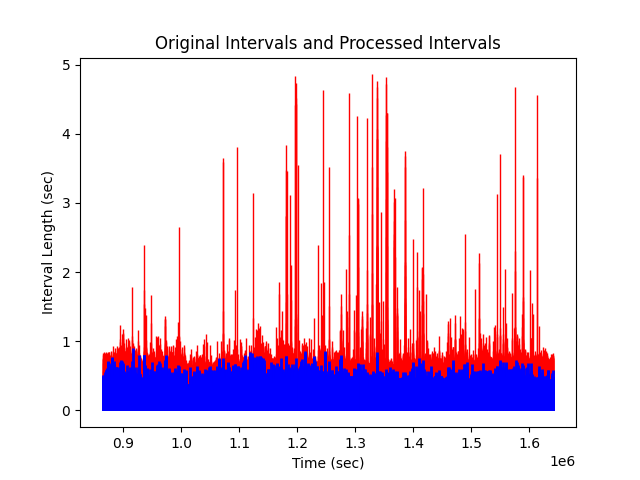

In [19]:
fig = plt.figure()
plt.vlines(pd.Series(df_buffer.index), 0, df_buffer["interval"], linewidth=1, color="red")
plt.vlines(pd.Series(df.index), 0, df["interval"], linewidth=2, color="blue")
plt.xlabel("Time (sec)")
plt.ylabel("Interval Length (sec)")
plt.title("Original Intervals and Processed Intervals")
plt.show()

In [20]:
print(imputed)

23143


In [21]:
print(max_imputed)

17


In [21]:
print("The proportion of beats that are imputed is " + str( round( imputed / len(df["interval"]), 4 ) ))

The proportion of beats that are imputed is 0.011


In [22]:
print("The maximum number of imputed beats is " + str(max_imputed))

The maximum number of imputed beats is 17


In [ ]:
# One thing I didn't compute in this run that would be good to know is how many times the < 0.25 exception was thrown

In [23]:
1.8/0.361

4.986149584487535

In [20]:
virtual_memory()

svmem(total=12655771648, available=600690688, percent=95.3, used=12055080960, free=600690688)

In [23]:
df

,interval
time,
2.500043e-01,0.250004
2.500142e-01,0.250014
2.500170e-01,0.250017
2.500656e-01,0.250066
2.500730e-01,0.250073
...,...
1.641598e+06,0.376226
1.641599e+06,0.382623
1.641599e+06,0.368281


In [43]:
for i in range(1,len(times)):
    prev = times[i-1]; curr = times[i]
    pieces = round( df.loc[curr,"interval"] / df.loc[prev,"interval"])

    if pieces >= 2: # Then it is likely that the current interval is a multiple interval
        fill_value = df.loc[curr,"interval"] / pieces

        while fill_value < 0.25: # We have too many pieces and the beats are unrealistically small (i.e. < 0.25 seconds)
            pieces -= 1
            fill_value = df.loc[curr,"interval"] / pieces
            if pieces == 1:
                break
        
        if pieces == 1: # Then there's no point in carrying on with this iteration
            continue

        # Otherwise, we impute the RR intervals in the most straightforward way
        endpoints = [i*fill_value for i in range(1, pieces)] + [curr]
        for t in endpoints:
            df.loc[t, "interval"] = fill_value

df.sort_index(inplace=True)


# THIS IS WAAAY TOO SLOW
    
    



KeyboardInterrupt: 

864001.1442410946

In [42]:
for i in range(1,1):
    print(i)

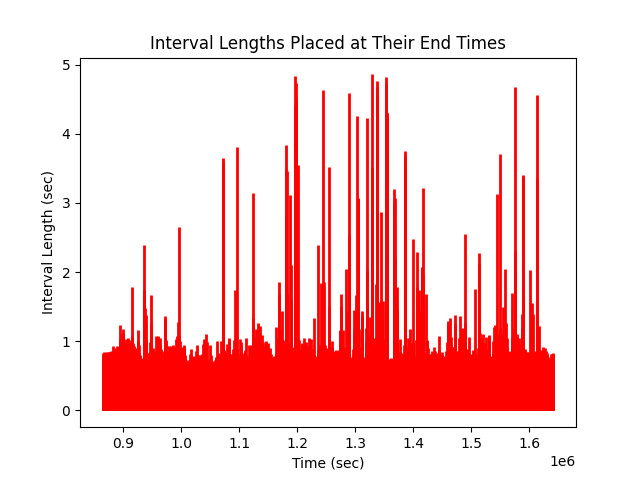

In [18]:
# STEP 3: We're going to try Joshua's suggestion: For each interval, compare it's length to the last interval
fig = plt.figure()
plt.vlines(df["time"], 0, df["interval"], color="red", linewidth=2)
plt.xlabel("Time (sec)")
plt.ylabel("Interval Length (sec)")
plt.title("Interval Lengths Placed at Their End Times")
plt.show()
    

In [33]:
virtual_memory()

svmem(total=12655771648, available=2306281472, percent=81.8, used=10349490176, free=2306281472)

In [10]:
df_copy = pd.DataFrame.copy(df, deep=True)

In [32]:
for i in range(1, len(df_copy["interval"]) ):
    pieces = round(df_copy.loc[i,"interval"] / df_copy.loc[i-1,"interval"])
    if pieces > 1:
        print(i)
        print(pieces)
        break

322
2


In [17]:
test_df = pd.DataFrame([[1,2],[3,4],[5,6]])

In [18]:
test_df

,0,1
0,1,2
1,3,4
2,5,6


In [20]:
test_df.set_index(0, drop=True, inplace=True)

In [21]:
test_df

,1
0,
1,2
3,4
5,6


In [22]:
test_df.loc[2, 1] = "TEST"

In [23]:
test_df

,1
0,
1,2.0
3,4.0
5,6.0
2,TEST


In [24]:
test_df.sort_index(inplace=True)

In [25]:
test_df

,1
0,
1,2.0
2,TEST
3,4.0
5,6.0
